In [88]:
# Normal imports
import pandas as pd
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## General GenSim packages to import

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# pyLDAvis for gensim

import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim  # don't skip this

# Temporal models
from gensim.models import LdaSeqModel
from gensim.models.wrappers.dtmmodel import DtmModel

# Enable logging for gensim - to get pink boxes
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Sklearn CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# A lot of warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pickle

In [26]:
def document_breakdown(sparse_corpus):
    # Bound even though it doesn't say much
    print("Bound of LDA model: ", lda_model.bound(corpus_vect_gensim))

    # Estimate for the corpus
    topic_count = []
    confidence = []
    both = []
    one_topic = 0
    two_topic = 0
    three_topic = 0
    four_more_topic = 0
    for num, doc in enumerate(range(len(sparse_corpus))):
        item = lda_model.get_document_topics(sparse_corpus[num])
        if len(item) == 1:
            topic_count.append(item[0][0])
            confidence.append(item[0][1])
            one_topic += 1
        else:
            pickin_best = []
            for it in item:
                pickin_best.append(it[1])
            for it in item:
                if it[1] == max(pickin_best):
                    topic_count.append(it[0])
                    confidence.append(it[1])
            if len(item) == 2:
                two_topic += 1
            if len(item) == 3:
                three_topic += 1
            if len(item) >= 4:
                four_more_topic += 1
# Topic winners over time
    enumed = list(range(len(topic_count)))
    topic_winners_time = pd.DataFrame(data = [enumed, topic_count]).T
    topic_winners_time.columns = ['chap_num', 'topic_winner']                

# Creating a scatter plot by topic, but first a dataframe
    topic_hue = pd.DataFrame([topic_count, confidence]).T
    topic_hue.columns = ['topic', 'confidence']
    sns.boxplot(x="topic", y="confidence", data=topic_hue)
#sns.lmplot(x=0, y=1, data= topic_hue, fit_reg=False, hue='trunc_model', legend=False, size = 8)

    print(len(topic_count))
# topic_count = []
# # Count of different doc topics
# for num, doc in enumerate(range(len(corpus_vect_gensim))):
#     topic_count.append(lda_model.get_document_topics(corpus_vect_gensim[num][0][0]))
    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(15,10))
    axes[0,0].hist(topic_count, bins = num_of_topics)
    axes[0, 0].set_title('Winning Topic Count');
    axes[0,1].hist(confidence);
    axes[0,1].set_title('Confidence Histogram');
    axes[1,0].bar(x = 'chap_num', height = 'topic_winner', data = topic_winners_time);
    axes[1,0].set_title('Winner by Chapter');
    axes[1,1].bar(x = ['One Topic', 'Two Topic', 'Three Topic', 'Four or More Topic'], height = [one_topic, two_topic, three_topic, four_more_topic])
    axes[1,1].set_title('Topic Classification Split')


In [27]:
# Creating a readable dictionary file for pyLDA and DTM
def readable_dict(vectorized_corpus, vectorizer):
    corpus_df = pd.DataFrame(vectorized_corpus.A, columns=vectorizer.get_feature_names())
    corpus_all_list = []
    for corpus in vectorized_corpus.toarray():
        coprus_words = []
        for idd, y in enumerate(corpus):
            if y == 0:
                pass
            else:
                coprus_words.append(corpus_df.columns[idd])
        corpus_all_list.append(coprus_words)

In [28]:
def word_impact(lda_model):
        topic_words = []
        topic_words_id = []
        topic_impact = []
        topic_id = []
        for x in range(num_of_topics):
            topic_terms = lda_model.show_topic(x, 30)
            for y in topic_terms:
                word, impact = y
                topic_words.append(word)
                topic_impact.append(impact)
                topic_id.append(x)
            topic_terms = lda_model.get_topic_terms(x, 30)
            for z in topic_terms:
                word_id, _ = z
                topic_words_id.append(word_id)
        word_topic_impact = pd.DataFrame([topic_words, topic_words_id, topic_impact, topic_id]).T
        word_topic_impact.columns = ['word', 'words_id', 'impact', 'topic_num']
        rank_count = word_topic_impact.groupby(by = 'words_id').count().sort_values('words_id', ascending = False) #.reset_index().reset_index()
        rank_count = rank_count.sort_values('impact', ascending = False).reset_index().reset_index()
        rank_count
        rank_count.drop(labels = ['topic_num', 'word',], axis = 1, inplace = True)
        rank_count.columns = ['count_topic_rank', 'words_id', 'count']
        rank_count.head()
        word_topic_impact['words_id'] = word_topic_impact['words_id'].astype(int)
        word_topic_impact['topic_num'] = word_topic_impact['topic_num'].astype(int)
        word_topic_impact['impact'] = word_topic_impact['impact'].astype(float)
        word_topic_impact = word_topic_impact.merge(rank_count, how = 'left', on = 'words_id')
        impact_avg = word_topic_impact.groupby(by = 'word').mean().reset_index()
        impact_avg.drop(labels = ['words_id', 'topic_num', 'count_topic_rank', 'count'], axis = 1, inplace = True)
        impact_avg.columns = ['word', 'impact_avg']
        impact_avg.head()
        word_topic_impact = word_topic_impact.merge(impact_avg, how = 'left', on = 'word')
        return word_topic_impact.sort_values(by = 'impact_avg', ascending = False).head(15)

vectorizer = CountVectorizer(stop_words='english', max_df = .35, min_df = 100, ngram_range = (1, 2))

pri doc no num (first) --> vectorizer = CountVectorizer(stop_words='english', max_df = .35, min_df = 50, ngram_range = (1, 3))
pri doc no num (first)--> eta .25, decay .7 assym

In [20]:
df_pri = pd.read_csv('./text/df_pri.csv')
df_pri = df_pri.sort_values('len', ascending = True)[6:]
df_pri = df_pri.sort_values('year', ascending = True)


In [204]:
df_pri

,Unnamed: 0,auth,title,date,year,doc,chapter_lemma,len
0,0,George Washington,Rules of Civility & Decent Behavior In Company...,,0,1 Every action done in company ought to be wit...,1 action company ought sign respect present 2 ...,1177
5,5,Frederick Jackson Turner,The Significance of History,,0,The conceptions of history have been almost as...,conception history numerous man write history ...,3349
6,6,Various,Excerpts of Colonial Laws related to Religious...,,0,"Articles, Laws, and Orders, Divine, Politic, a...",article law order divine politic martial colon...,1807
4,4,Woodrow Wilson,Excerpts from the President’s Committee on Adm...,,0,"pp. 10, 11, 39-42 The board form of organiza...",pp 10 11 39 42 board form organization unsuite...,1509
1,1,NaN,NaN,NaN,0,Footage from Sing Sing prison was shown. Frenc...,footage sing sing prison show french aristocra...,119
7,7,NaN,Magna Carta,1215,1215,"Preamble John, by the grace of God, king of En...",preamble john grace god king england lord irel...,1999
8,8,NaN,First Charter of Virginia,"April 10, 1606",1606,"I. JAMES, by the Grace of God, King of Englan...",i. jame grace god king england scotland france...,1673
9,9,NaN,"Articles, Laws, and Orders, Divine, Politic, a...",1610,1610,"Articles, Lawes, and Orders, Divine, Politique...",article lawe order divine politique martiall c...,343
10,10,NaN,General Charter for Those who Discover Any New...,"March 27, 1614",1614,"The States-General of the United Netherlands, ...",state general united netherland shall present ...,270
11,11,NaN,Grant of Exclusive Trade to New Netherland by ...,"October 11, 1614",1614,"The States-General of the United Netherlands, ...",state general united netherland present shall ...,327


/Users/bengreer/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


(1600, 2000)

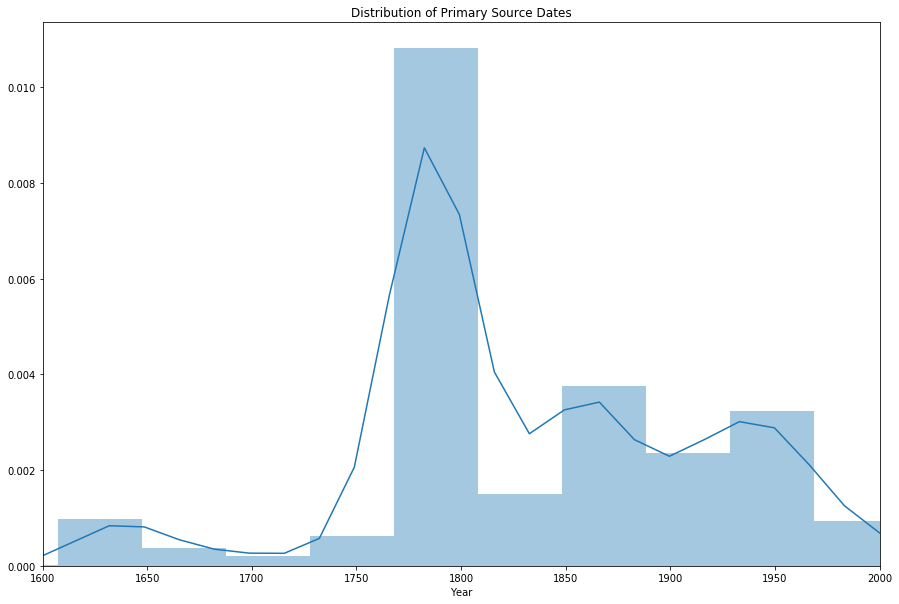

In [209]:
# Histogram of the histogram
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(df_pri['year'])
plt.title("Distribution of Primary Source Dates")
plt.xlabel('Year')
plt.xlim(left = 1600, right = 2000)

In [279]:
num_of_topics = 10

vectorizer = CountVectorizer(stop_words='english', max_df = .5, min_df = 50, ngram_range = (1, 3))


corpus_count = vectorizer.fit_transform(df_pri['chapter_lemma'])


#transform to gensim acceptable objects
vocab = vectorizer.get_feature_names()

id2word = dict([(i, s) for i, s in enumerate(vocab)])

corpus_vect_gensim = gensim.matutils.Sparse2Corpus(corpus_count, documents_columns=False)

readable_dict(corpus_count, vectorizer)



In [280]:
readable_dict(corpus_count, vectorizer)

In [281]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_vect_gensim,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           update_every=1,
                                           passes=10,
                                           per_word_topics=True,
                                           alpha='symmetric',
                                           eta = .8,
                                           decay = .7)

In [282]:
corpus_count

<1719x3553 sparse matrix of type '<class 'numpy.int64'>'
	with 574086 stored elements in Compressed Sparse Row format>

In [273]:
for idx, x in enumerate(lda_model.print_topics(num_words = 20, num_topics = num_of_topics)):
    print("Topic {}:".format(idx), x)
doc_lda = lda_model[corpus_vect_gensim]

Topic 0: (0, '0.009*"colony" + 0.009*"king" + 0.008*"parliament" + 0.007*"britain" + 0.006*"authority" + 0.006*"great britain" + 0.005*"treaty" + 0.005*"england" + 0.005*"british" + 0.004*"nature" + 0.004*"america" + 0.004*"constitution" + 0.004*"person" + 0.004*"common" + 0.004*"duty" + 0.004*"reason" + 0.004*"civil" + 0.003*"principle" + 0.003*"ought" + 0.003*"article"')
Topic 1: (1, '0.010*"world" + 0.006*"force" + 0.006*"peace" + 0.005*"america" + 0.005*"policy" + 0.005*"soviet" + 0.005*"freedom" + 0.004*"president" + 0.004*"economic" + 0.004*"work" + 0.004*"life" + 0.004*"national" + 0.003*"political" + 0.003*"need" + 0.003*"way" + 0.003*"action" + 0.003*"military" + 0.003*"security" + 0.003*"europe" + 0.003*"believe"')
Topic 2: (2, '0.008*"god" + 0.007*"life" + 0.005*"world" + 0.005*"work" + 0.004*"slave" + 0.004*"slavery" + 0.004*"negro" + 0.004*"human" + 0.004*"race" + 0.004*"let" + 0.003*"like" + 0.003*"way" + 0.003*"mind" + 0.003*"live" + 0.003*"nature" + 0.003*"society" + 0.

In [274]:
cm = CoherenceModel(model= lda_model, corpus = corpus_vect_gensim, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-0.7876912284021654

In [275]:
word_impact(lda_model)

,word,words_id,impact,topic_num,count_topic_rank,count,impact_avg
90,negro,2096,0.021947,3,42,2,0.013020
66,negro,2096,0.004093,2,42,2,0.013020
92,black,368,0.010254,3,83,1,0.010254
94,south,3005,0.009580,3,129,1,0.009580
80,white,3490,0.002902,2,44,2,0.009536
91,white,3490,0.016170,3,44,2,0.009536
210,constitution,675,0.015843,7,3,5,0.009512
120,constitution,675,0.011951,4,3,5,0.009512
270,constitution,675,0.013021,9,3,5,0.009512
255,constitution,675,0.002514,8,3,5,0.009512


Bound of LDA model:  -8875094.215138257
1719


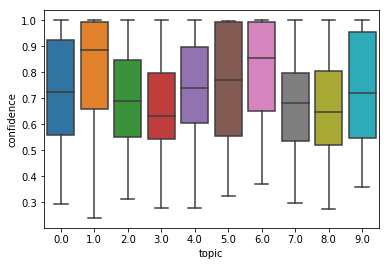

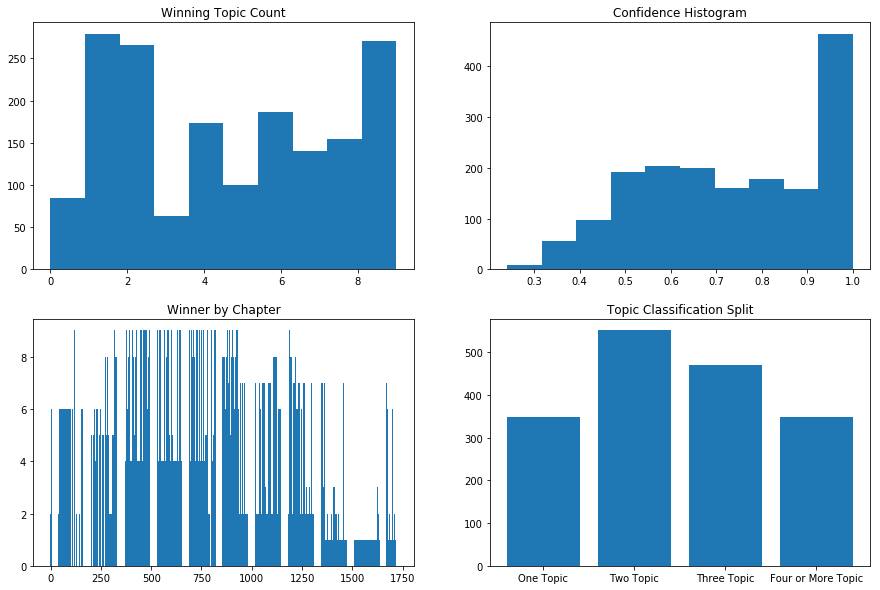

In [276]:
document_breakdown(corpus_vect_gensim)

In [283]:
    topic_count = []
    confidence = []
    both = []
    one_topic = 0
    two_topic = 0
    three_topic = 0
    four_more_topic = 0
    for num, doc in enumerate(range(len(corpus_vect_gensim))):
        item = lda_model.get_document_topics(corpus_vect_gensim[num])
        if len(item) == 1:
            topic_count.append(item[0][0])
            confidence.append(item[0][1])
            one_topic += 1
        else:
            pickin_best = []
            for it in item:
                pickin_best.append(it[1])
            for it in item:
                if it[1] == max(pickin_best):
                    topic_count.append(it[0])
                    confidence.append(it[1])
            if len(item) == 2:
                two_topic += 1
            if len(item) == 3:
                three_topic += 1
            if len(item) >= 4:
                four_more_topic += 1
                
    enumed = list(range(len(topic_count)))
    topic_winners_time = pd.DataFrame(data = [enumed, topic_count]).T
    topic_winners_time.columns = ['chap_num', 'topic_winner']             

In [285]:
topic_map_names = {0 : 'Colony', 1 : 'America Dream', 2 : 'Early America',  3 : 'South', 4 : 'Government Branches 1',
               5 : 'Government Military', 6 : 'Government Branches 2', 7 : 'Government Branches 3', 8 : 'Revolution', 9 : 'Founding'  }

replacement = topic_winners_time['topic_winner'] 

topic_winners_time['topic_winner_names'] = replacement

topic_winners_time['topic_winner_names'] = topic_winners_time['topic_winner_names'].map(topic_map_names)
# for x in topic_winners_time['topic_winner']:
#     str(x).map(x, topic_map_names[x])

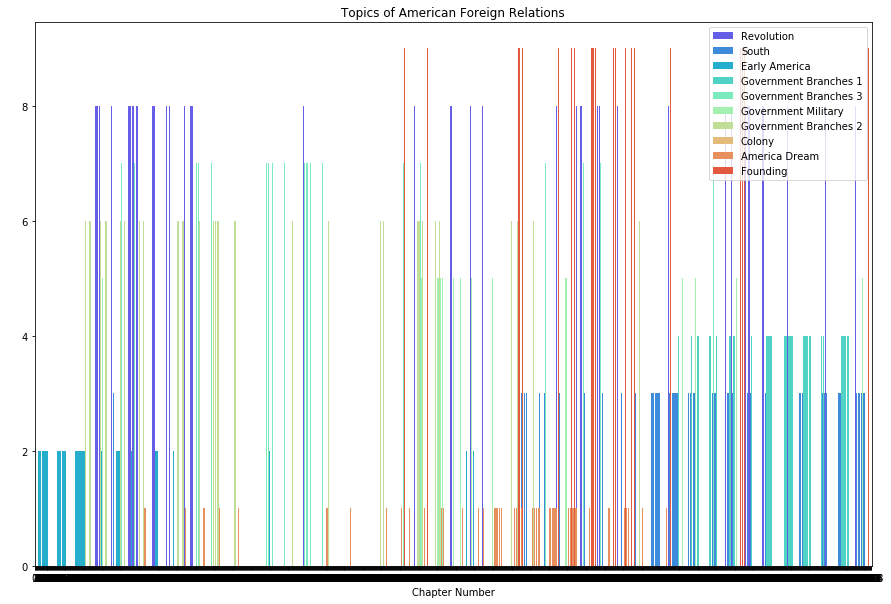

In [286]:
fig, ax = plt.subplots(figsize=(15,10))

sns.barplot(x = 'chap_num', y = 'topic_winner', data = topic_winners_time, hue = 'topic_winner_names', palette="rainbow")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
plt.title('Topics of American Foreign Relations')
plt.xlabel('Chapter Number')
plt.ylabel(' ')
plt.legend()
change_width(ax, .5)
plt.show()

In [243]:
corpus_df = pd.DataFrame(corpus_count.A, columns=vectorizer.get_feature_names())
corpus_all_list = []
for corpus in corpus_count.toarray():
    coprus_words = []
    for idd, y in enumerate(corpus):
        if y == 0:
            pass
        else:
            coprus_words.append(corpus_df.columns[idd])
    corpus_all_list.append(coprus_words)

In [244]:
# Setting up a pyLDA readable dict
id2word = corpora.Dictionary(corpus_all_list)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_vect_gensim, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.130612  0.021741       1        1  15.430811
3      0.044054 -0.084841       2        1  15.413089
1     -0.030395 -0.040374       3        1  13.493969
9     -0.095575  0.007122       4        1  11.582083
5     -0.032663  0.048031       5        1   9.893780
8     -0.027335 -0.010319       6        1   9.837506
0      0.125879 -0.030569       7        1   7.605504
6      0.125186  0.074944       8        1   6.893518
2      0.049942  0.027922       9        1   5.992611
4     -0.028481 -0.013657      10        1   3.857138, topic_info=     Category         Freq                  Term        Total  loglift  \
term                                                                     
750   Default  4727.000000                   non  4727.000000  30.0000   
2937  Default  2335.000000                temper  2335.000000  29.0000   
1399  Default  2283.000000                honest  2283.000000  28.0000   
2069  Default  2827.000000               deserve  2827.000000  27.0000   
2390  Default  3334.000000                subdue  3334.000000  26.0000   
2200  Default  2484.000000           prosecution  2484.000000  25.0000   
2934  Default  2158.000000                 shock  2158.000000  24.0000   
714   Default  2371.000000          love country  2371.000000  23.0000   
1432  Default  1382.000000                  path  1382.000000  22.0000   
2974  Default  1008.000000          state people  1008.000000  21.0000   
544   Default  1534.000000                empire  1534.000000  20.0000   
267   Default  1796.000000                repeat  1796.000000  19.0000   
1830  Default  2319.000000                 beast  2319.000000  18.0000   
3407  Default  2167.000000                   mrs  2167.000000  17.0000   
3448  Default  2111.000000      supreme law land  2111.000000  16.0000   
1033  Default  1739.000000        advice consent  1739.000000  15.0000   
2532  Default  1968.000000           industrious  1968.000000  14.0000   
2138  Default  1918.000000         respect right  1918.000000  13.0000   
139   Default   781.000000             excessive   781.000000  12.0000   
3187  Default  1663.000000       promote general  1663.000000  11.0000   
3495  Default   650.000000                racial   650.000000  10.0000   
3194  Default  1075.000000             civil war  1075.000000   9.0000   
219   Default  1340.000000                  near  1340.000000   8.0000   
740   Default  1370.000000                 money  1370.000000   7.0000   
366   Default  1414.000000                actual  1414.000000   6.0000   
2137  Default  2044.000000               rejoice  2044.000000   5.0000   
2644  Default  2345.000000             arbitrary  2345.000000   4.0000   
3273  Default  1268.000000               pervade  1268.000000   3.0000   
747   Default  1107.000000              national  1107.000000   2.0000   
1957  Default  2571.000000               protest  2571.000000   1.0000   
...       ...          ...                   ...          ...      ...   
643   Topic10    19.578552                  holy   122.651100   1.4203   
1033  Topic10   276.239502        advice consent  1739.228882   1.4153   
543   Topic10    57.947056              emphasis   375.193848   1.3873   
2829  Topic10   119.902222                  earn   794.783264   1.3639   
2390  Topic10   429.067505                subdue  3334.369629   1.2048   
463   Topic10    45.687618              conquest   295.091797   1.3898   
3407  Topic10   262.319550                   mrs  2167.775879   1.1434   
1162  Topic10   152.699112                harbor  1258.064575   1.1464   
2564  Topic10    64.376633              garrison   454.535034   1.3007   
0     Topic10    93.478271                    10   740.494324   1.1857   
1907  Topic10   127.830612              northern  1151.722534   1.0569   
2937  Topic10   197.490219                temper  233

In [232]:
lda_model.save(fname= './gensim_lda_model/pri_doc2')
pickle.dump(corpus_vect_gensim ,open('./gensim_lda_model/pri_doc2.txt', 'wb'))
pickle.dump(corpus_count ,open('./gensim_lda_model/pri_doc2.txt', 'wb'))

### Load in Secondary Source Documents

In [104]:
df_sec = pd.read_csv('./text/sec_chapters_all.csv')

In [289]:

pri_sec_countvec = vectorizer.transform(df_sec['chapter_lemma'])

pri_corpus_vect_gensim = gensim.matutils.Sparse2Corpus(pri_sec_countvec, documents_columns=False)


Bound of LDA model:  -8880499.133851033
42


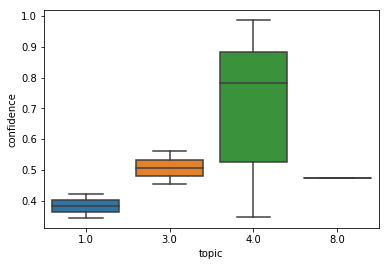

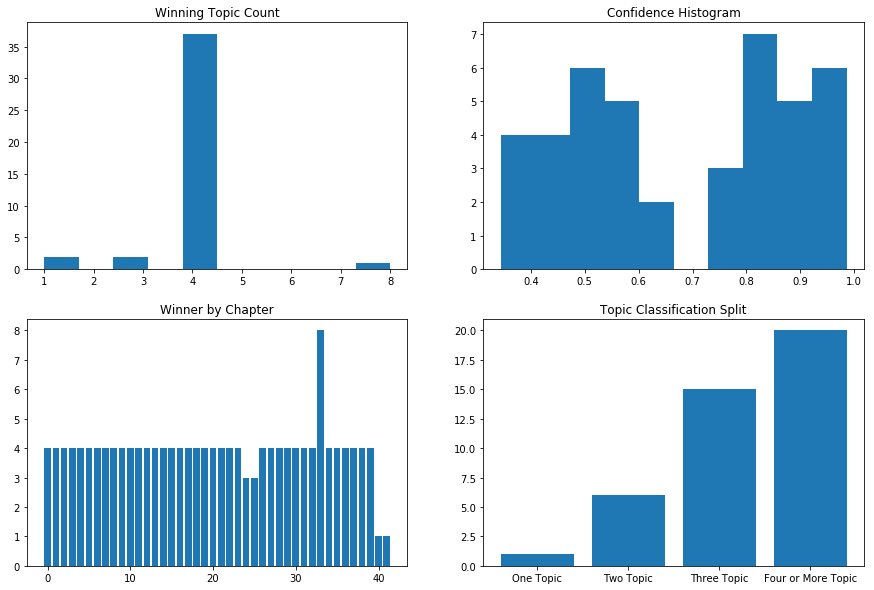

In [290]:
document_breakdown(pri_corpus_vect_gensim)

### DTM Modeling

In [248]:
df_sec.head(26)

,Unnamed: 0,chapter,chapter_lemma,chapter_gensim_lemma,len,ner
0,At_War’s_End,Allied forces returned to France in June 1944 ...,ally force return france june 1944 soon battle...,"['ally', 'force', 'return', 'france', 'june', ...",3174,allied france june 1944 normandy washington fr...
1,Origins_of_the_Cold_War,The end of the killing brought enormous relief...,end killing bring enormous relief people world...,"['end', 'killing', 'bring', 'enormous', 'relie...",7015,germans japanese years german japanese soviet ...
2,The_Korean_War_and_Its_Consequences,The principal focus of Soviet-American tension...,principal focus soviet tension europe soviet c...,"['principal', 'focus', 'soviet', 'tension', 'e...",3944,soviet - american europe soviets eastern europ...
3,New_Leaders_and_New_Arenas_in_the_Cold_War,Stalin died. Slowly the terror eased within th...,stalin die slowly terror ease soviet union esp...,"['stalin', 'die', 'slowly', 'terror', 'ease', ...",7408,stalin soviet union lavrenti beria georgii mal...
4,Crisis_Resolution,The tension of the years 1958–62 was without p...,tension year 1958–62 parallel decade follow wo...,"['tension', 'year', '1958–62', 'parallel', 'de...",4491,years 1958–62 parallel decades world war ii be...
5,America’s_Longest_War,America’s war in Vietnam is the textbook examp...,america ’s war vietnam textbook example great ...,"['america', '’s', 'war', 'vietnam', 'textbook'...",6375,america vietnam american american vietnam mark...
6,The_Rise_and_Fall_of_Détente,"In 1969, when Richard Nixon, Cold Warrior pers...",1969 richard nixon cold warrior personified en...,"['1969', 'richard', 'nixon', 'cold', 'warrior'...",6730,1969 richard nixon cold warrior white house am...
7,In_God’s_Country,If anyone ever doubted that America was God’s ...,doubt america god ’ choose country event 1980 ...,"['doubt', 'america', 'god', '’', 'choose', 'co...",5124,america 1980s ronald reagan american reagan am...
8,"America_and_the_World,_1945–199",The era herein reviewed began in the closing m...,era review begin closing month world war ii en...,"['era', 'review', 'begin', 'closing', 'month',...",2880,months world war ii soviet union soviet - amer...
9,1The_New_World_Order,"For more than four decades, the lodestar of Am...",decade lodestar foreign policy opposition sovi...,"['decade', 'lodestar', 'foreign', 'policy', 'o...",10246,decades american soviet union end cold war sov...


In [ ]:
# Setting up the DTM corpus and for the pyLDA viz

id2word = corpora.Dictionary(corpus_all_list)

class DTMcorpus(corpora.textcorpus.TextCorpus):

    def get_texts(self):
        return self.input

    def __len__(self):
        return len(self.input)

corpus = DTMcorpus(corpus_all_list)

In [ ]:
# Save model to disk.
temp_file = datapath("mode")
lda_model.save(temp_file)

# loading it for good measure but the LDA model just needs to be saved in the same area to be initialized by dtm model
lda = LdaModel.load(temp_file)

# Setting up the other parameters to go in
dtm_path = '/Users/bengreer/Documents/github/DSI-US-5/Capstone/dtm/bin/dtm-darwin64'
time_seq = [250, 250,250, 250, 250, 250, 225] # the # of chapters which are included in each book, the largest timeframe I can have

model = DtmModel(dtm_path, pri_cvec_gensim, time_seq, num_topics=5,
                 id2word=id2word, initialize_lda=True)

In [ ]:
# exploring the outcome of the DTM model
topics = model.show_topic(topicid=1, time=6, num_words=20)
topics

In [ ]:
def read_topic_word_dist(topic, journal_df, output_prefix):
    word_dist_file = output_prefix + str(topic) + '-var-e-log-prob.dat'
    word_dist = np.fromfile(word_dist_file, sep='\n')
    
    # reshape the numpy array
    ncols = journal_df.pub_year.nunique()
    nrows = len(vocab)
    word_dist = np.reshape(word_dist, (nrows, ncols))
    
    # convert the numpy ndarray to pandas dataframe
    return pd.DataFrame(word_dist, 
                        columns=np.sort(journal_df.pub_year.unique()).tolist())

In [ ]:
def top_words(topic_word_dist, vocab, year, num_words=10):
    indices = topic_word_dist.loc[:,year].sort_values(ascending=False).head(num_words).index
    return vocab.loc[indices, :]

In [ ]:
def all_top_words(topics, journal_df, vocab, ouput_prefix):
    for topic in topics:
        word_dist = read_topic_word_dist(topic, journal_df, output_prefix)
        print('Topic {}'.format(topic))
        for year in np.sort(journal_df.pub_year.unique()):
            print("{}:\n{}\n".format(year, top_words(word_dist, vocab, year, 20).word.tolist()))
        print('-'*25)

In [ ]:
output_prefix = '/media/fay/38E0D529E0D4EE5E/Users/Fay/Documents/GA/GA_capstone/data/jcb_10topics/model_run/lda-seq/topic-0'
n_topics = 10
topics = [str(i) if i > 9 else '0' + str(i) for i in range(n_topics)]

all_top_words(topics, , vocab, output_prefix)